In [1]:
import json
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

def LoadJson(file_name):
    import json,yaml
    JSONPATH = os.path.join(file_name)
    return yaml.safe_load(open(JSONPATH))

data_dict = LoadJson('preprocessing_200.json')

def revert_logit(x):
    alpha = 1e-6
    exp = np.exp(x)
    x = exp/(1+exp)
    return (x-alpha)/(1 - 2*alpha)

def revert(x,name='cell'):
    x = x*data_dict['std_{}'.format(name)] + data_dict['mean_{}'.format(name)]
    x = revert_logit(x)
    x = x * (np.array(data_dict['max_{}'.format(name)]) -data_dict['min_{}'.format(name)]) + data_dict['min_{}'.format(name)]
    return x

In [2]:
   def preprocessing(cells,clusters,save_json=False):
          num_part = cells.shape[1]

          cells=cells.reshape(-1,cells.shape[-1]) #flattens D0 and D1

          def _logit(x):
              alpha = 1e-6
              x = alpha + (1 - 2*alpha)*x
              return np.ma.log(x/(1-x)).filled(0)

          #Transformations
          data_dict = LoadJson('preprocessing_{}.json'.format(200))

          #normalize
          clusters[:,:] = np.ma.divide(clusters[:,:]-data_dict['min_cluster'],np.array(data_dict['max_cluster'])- data_dict['min_cluster']).filled(0)
          cells[:,:-1]= np.ma.divide(cells[:,:-1]-data_dict['min_cell'],np.array(data_dict['max_cell'])- data_dict['min_cell']).filled(0)

          # make gaus-like.
          clusters = _logit(clusters)
          cells[:,:-1] = _logit(cells[:,:-1])
    
          # standard scalar
          clusters = np.ma.divide(clusters-data_dict['mean_cluster'],data_dict['std_cluster']).filled(0)
          cells[:,:-1]= np.ma.divide(cells[:,:-1]-data_dict['mean_cell'],data_dict['std_cell']).filled(0)

          cells = cells.reshape(clusters.shape[0],num_part,-1)
          print(f"\nL 380: Shape of Cells in DataLoader = {np.shape(cells)}")
          print(f"\nL 381: Cells in DataLoader = \n{cells[0,15:20,:]}")
         #print(f"\nL 382: Clusters in DataLoader = {clusters}\n")
          return cells.astype(np.float32),clusters.astype(np.float32)

In [3]:
from utils import *

2023-06-02 10:18:29.647277: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 10:18:31.646207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
geant4_name = "improved_200cells_FPCD.hdf5"
geant4_name = "smeared_20keV_200cells_FPCD.hdf5"
geant4_name = "newMIP_smeared_20keV_200cells_FPCD.hdf5"

g4 = h5py.File(geant4_name, 'r')

print(g4.keys())

nevts = 1_000
clusters = g4['cluster'][:nevts,2:]
cells = g4['hcal_cells'][:nevts]
cells[:,:,0] = np.log10(cells[:,:,0])
MASK = cells[:,:,-1]

<KeysViewHDF5 ['cluster', 'hcal_cells']>


/tmp/ipykernel_127590/2638624606.py:12: RuntimeWarning: divide by zero encountered in log10
  cells[:,:,0] = np.log10(cells[:,:,0])


In [5]:
p_cells, p_clusters = preprocessing(cells, clusters)


L 380: Shape of Cells in DataLoader = (1000, 200, 5)

L 381: Cells in DataLoader = 
[[ 0.49270093  1.4865904   0.30417705 -0.04054631  1.        ]
 [ 0.5642355   1.4233966   0.38169798  0.00515511  1.        ]
 [ 0.14198914  1.4541855   0.32555857  0.09308619  1.        ]
 [ 0.3213517   1.5799106   0.32040486  0.15006053  1.        ]
 [ 0.22224635  1.6523601   0.37665504  0.22861853  1.        ]]


In [6]:
g4_cellsX = g4['hcal_cells'][:nevts,:,1]
g4_cellsY = g4['hcal_cells'][:nevts,:,2]
g4_cellsZ = g4['hcal_cells'][:nevts,:,3]
g4_cellsE = g4['hcal_cells'][:nevts,:,0]

MASK = g4['hcal_cells'][:nevts,:,-1] == 1
print(np.shape(g4_cellsX))
masked_X = g4_cellsX[MASK]
masked_Y = g4_cellsY[MASK]
masked_Z = g4_cellsZ[MASK]
masked_E = np.log10(g4_cellsE[MASK])

(1000, 200)


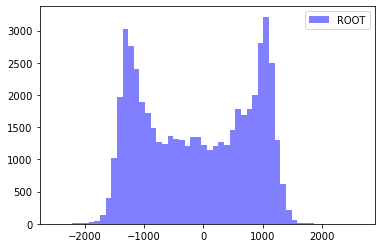

In [7]:
plt.hist(masked_X,bins=54,label = "ROOT",color="blue",alpha=0.5)
_ = plt.legend()

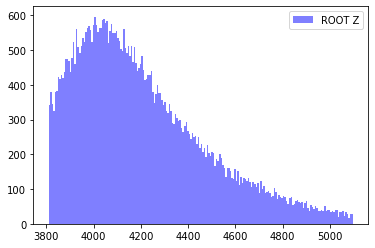

In [8]:
plt.hist(masked_Z,bins=200,label = "ROOT Z",color="blue",alpha=0.5)
_ = plt.legend()

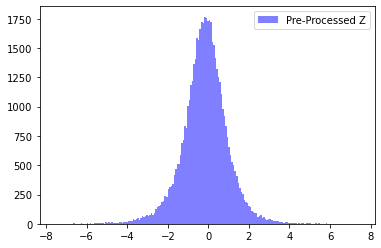

In [9]:
plt.hist(np.ravel(p_cells[:,:,3][MASK]),bins = 200,label = "Pre-Processed Z",color="blue",alpha=0.5)
_ = plt.legend()

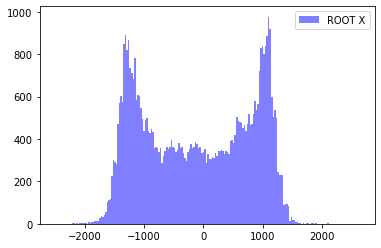

In [10]:
plt.hist(masked_X,bins=200,label = "ROOT X",color="blue",alpha=0.5)
_ = plt.legend()

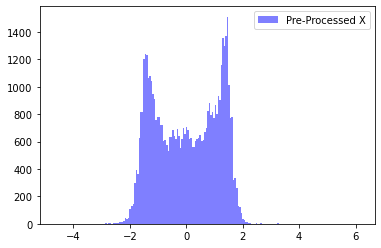

In [11]:
plt.hist(np.ravel(p_cells[:,:,1][MASK]),bins = 200,label = "Pre-Processed X",color="blue",alpha=0.5)
_ = plt.legend()

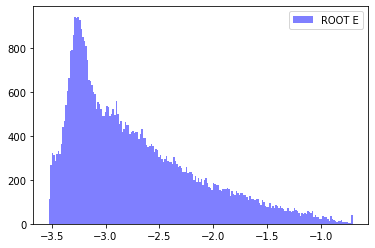

In [12]:
plt.hist(masked_E,bins=200,label = "ROOT E",color="blue",alpha=0.5)
_ = plt.legend()

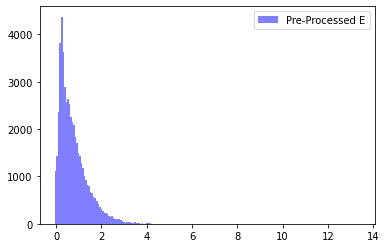

In [13]:
plt.hist(np.ravel(p_cells[:,:,0][MASK]),bins=200,label = "Pre-Processed E",color="blue",alpha=0.5)
_ = plt.legend()

In [14]:
print(p_cells[:,:,0][MASK])

[0.09998343 0.32138985 0.17665263 ... 1.2674674  0.77791166 1.6754057 ]


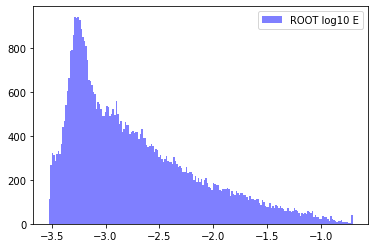

In [15]:
plt.hist(masked_E,bins=200,label = "ROOT log10 E",color="blue",alpha=0.5)
_ = plt.legend()

In [16]:
print(masked_E)

[-3.3875532 -3.1681507 -3.3133585 ... -2.1640086 -2.6819625 -1.7819204]
